# Introduction

The aim of this project is to perform satellite image classification on the EuroSAT dataset, see https://github.com/phelber/EuroSAT. The authors present a novel dataset based on  Sentinel-2 satellite images. The dataset has 13 spectral bands, and includes 10 classes with 27,000 labelled and geo-referenced images. This project will compare various CNN models to the Mobile-ViT model.

The notebook below tests a Mobile-ViT model, which is based on the paper, found here: https://arxiv.org/abs/2110.02178

The implementation is based on the tutorial below:
https://colab.research.google.com/github/keras-team/keras-io/blob/master/examples/vision/ipynb/mobilevit.ipynb

# Modifications

I first test the baseline code with no changes made. Then, I make 3 distinct modifications to the code as my own experiments to determine any improvements to the results. Furthermore, to run the code with the proposed changes, please comment/uncomment the code snippets where outlined. The code takes approximately 30 minutes to run, which varies depending on the modification(s) made.


The changes implemented are summarised below:

1. Change the patch size to 4x4 instead of the default 2x2. By applying a larger patch, it is expected that the model will train faster, as there are less patches to be applied to the image. However, this may come at a cost of accuracy, as a larger patch is less effective at capturing both global and local information between patches and neighbouring pixels.

2. Include a kernel regularizer for weight decay. We use L2 regularization in certain layers of the network to prevent overfitting.

3. 




# Imports

Import the required modules

In [1]:
# Install Tensorflow Addons
!pip install tensorflow-addons

     |████████████████████████████████| 1.1 MB 7.9 MB/s 


In [2]:
# Complete imports
import tensorflow as tf

from keras.applications import imagenet_utils
from tensorflow.keras import layers
from tensorflow import keras

import tensorflow_datasets as tfds
import tensorflow_addons as tfa

# from keras.regularizers import l2

tfds.disable_progress_bar()

# Define hyperparameters

**Change 1:**
We change the patch_size from 2 to 4

In [6]:
patch_size = 2 # CHANGE TO 4
image_size = 256
expansion_factor = 2  # expansion factor for the MobileNetV2 blocks

**Change 2:** We modify the code to include a kernel regularizer for weight decay. This change is implemented in all layers within all Conv2D, DepthWiseConv2D, and Dense layers in conv_block, the inverted_residual_block and the mlp block functions. It is anticipated that implementating L2 regularization in these functions will help to prevent overfitting and improve the overall performance of the model. 

See the commented sections where `kernel_regularizer=l2` is applied.

# Define Mobile-ViT network blocks

Create a conv block, an inverted residual block, a mlp, and a transformer block. See the design below for a summary, and refer to the paper for further discussion.

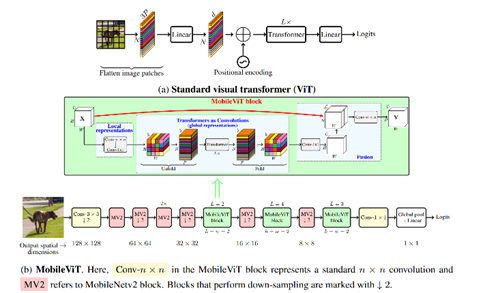

In [7]:
def conv_block(x, filters=16, kernel_size=3, strides=2):
    conv_layer = layers.Conv2D(
        filters, kernel_size, strides=strides, activation=tf.nn.swish, padding="same" #kernel_regularizer=l2
    )
    return conv_layer(x)


# Reference: https://git.io/JKgtC


def inverted_residual_block(x, expanded_channels, output_channels, strides=1):
    m = layers.Conv2D(expanded_channels, 1, padding="same", use_bias=False #kernel_regularizer=l2
                      )(x)
    m = layers.BatchNormalization()(m)
    m = tf.nn.swish(m)

    if strides == 2:
        m = layers.ZeroPadding2D(padding=imagenet_utils.correct_pad(m, 3))(m)
    m = layers.DepthwiseConv2D(
        3, strides=strides, padding="same" if strides == 1 else "valid", use_bias=False #kernel_regularizer=l2
    )(m)
    m = layers.BatchNormalization()(m)
    m = tf.nn.swish(m)

    m = layers.Conv2D(output_channels, 1, padding="same", use_bias=False #kernel_regularizer=l2)(m)
    m = layers.BatchNormalization()(m)

    if tf.math.equal(x.shape[-1], output_channels) and strides == 1:
        return layers.Add()([m, x])
    return m


# Reference:
# https://keras.io/examples/vision/image_classification_with_vision_transformer/


def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.swish #kernel_regularizer=l2)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x


def transformer_block(x, transformer_layers, projection_dim, num_heads=2):
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(x)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, x])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=[x.shape[-1] * 2, x.shape[-1]], dropout_rate=0.1,)
        # Skip connection 2.
        x = layers.Add()([x3, x2])

    return x


def mobilevit_block(x, num_blocks, projection_dim, strides=1):
    # Local projection with convolutions.
    local_features = conv_block(x, filters=projection_dim, strides=strides)
    local_features = conv_block(
        local_features, filters=projection_dim, kernel_size=1, strides=strides
    )

    # Unfold into patches and then pass through Transformers.
    num_patches = int((local_features.shape[1] * local_features.shape[2]) / patch_size)
    non_overlapping_patches = layers.Reshape((patch_size, num_patches, projection_dim))(
        local_features
    )
    global_features = transformer_block(
        non_overlapping_patches, num_blocks, projection_dim
    )

    # Fold into conv-like feature-maps.
    folded_feature_map = layers.Reshape((*local_features.shape[1:-1], projection_dim))(
        global_features
    )

    # Apply point-wise conv -> concatenate with the input features.
    folded_feature_map = conv_block(
        folded_feature_map, filters=x.shape[-1], kernel_size=1, strides=strides
    )
    local_global_features = layers.Concatenate(axis=-1)([x, folded_feature_map])

    # Fuse the local and global features using a convoluion layer.
    local_global_features = conv_block(
        local_global_features, filters=projection_dim, strides=strides
    )

    return local_global_features


# Create Mobile-ViT

Initialise the Mobile-ViT architecture with 10 classes, based on the EuroSAT dataset.

In [ ]:

def create_mobilevit(num_classes=10):
    inputs = keras.Input((image_size, image_size, 3))
    x = layers.Rescaling(scale=1.0 / 255)(inputs)

    # Initial conv-stem -> MV2 block.
    x = conv_block(x, filters=16)
    x = inverted_residual_block(
        x, expanded_channels=16 * expansion_factor, output_channels=16
    )

    # Downsampling with MV2 block.
    x = inverted_residual_block(
        x, expanded_channels=16 * expansion_factor, output_channels=24, strides=2
    )
    x = inverted_residual_block(
        x, expanded_channels=24 * expansion_factor, output_channels=24
    )
    x = inverted_residual_block(
        x, expanded_channels=24 * expansion_factor, output_channels=24
    )

    # First MV2 -> MobileViT block.
    x = inverted_residual_block(
        x, expanded_channels=24 * expansion_factor, output_channels=48, strides=2
    )
    x = mobilevit_block(x, num_blocks=2, projection_dim=64)

    # Second MV2 -> MobileViT block.
    x = inverted_residual_block(
        x, expanded_channels=64 * expansion_factor, output_channels=64, strides=2
    )
    x = mobilevit_block(x, num_blocks=4, projection_dim=80)

    # Third MV2 -> MobileViT block.
    x = inverted_residual_block(
        x, expanded_channels=80 * expansion_factor, output_channels=80, strides=2
    )
    x = mobilevit_block(x, num_blocks=3, projection_dim=96)
    x = conv_block(x, filters=320, kernel_size=1, strides=1)

    # Classification head.
    x = layers.GlobalAvgPool2D()(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    return keras.Model(inputs, outputs)


mobilevit_xxs = create_mobilevit()
mobilevit_xxs.summary()

# Apply data preprocessing

Apply data augmentation to the input images

In [9]:
batch_size = 64
auto = tf.data.AUTOTUNE
resize_bigger = 280
num_classes = 10


def preprocess_dataset(is_training=True):
    def _pp(image, label):
        if is_training:
            # Data augmentation
            image = tf.image.resize(image, (resize_bigger, resize_bigger))
            image = tf.image.random_crop(image, (image_size, image_size, 3))
            image = tf.image.random_flip_left_right(image)
        else:
            image = tf.image.resize(image, (image_size, image_size))
        label = tf.one_hot(label, depth=num_classes)
        return image, label

    return _pp


def prepare_dataset(dataset, is_training=True):
    if is_training:
        dataset = dataset.shuffle(batch_size * 10)
    dataset = dataset.map(preprocess_dataset(is_training), num_parallel_calls=auto)
    return dataset.batch(batch_size).prefetch(auto)


# Dataset preparation

We load the dataset with a 90%/10% train/validation split. This is a small difference to the CNN experiments.

In [10]:
train_dataset, val_dataset = tfds.load(
    "eurosat/rgb", split=["train[:90%]", "train[90%:]"], as_supervised=True
)

num_train = train_dataset.cardinality()
num_val = val_dataset.cardinality()
print(f"Number of training examples: {num_train}")
print(f"Number of validation examples: {num_val}")

train_dataset = prepare_dataset(train_dataset, is_training=True)
val_dataset = prepare_dataset(val_dataset, is_training=False)

Shuffling and writing examples to /root/tensorflow_datasets/eurosat/rgb/2.0.0.incompleteNBA92P/eurosat-train.tfrecord
Dataset eurosat downloaded and prepared to /root/tensorflow_datasets/eurosat/rgb/2.0.0. Subsequent calls will reuse this data.
Number of training examples: 24300
Number of validation examples: 2700


# Train the model

We train the model for 5 epochs and record the final validation accuracy.

In [11]:
learning_rate = 0.002
label_smoothing_factor = 0.1
epochs = 5

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
loss_fn = keras.losses.CategoricalCrossentropy(label_smoothing=label_smoothing_factor)


def run_experiment(epochs=epochs):
    mobilevit_xxs = create_mobilevit(num_classes=num_classes)
    mobilevit_xxs.compile(optimizer=optimizer, loss=loss_fn, metrics=["accuracy"])

    checkpoint_filepath = "/tmp/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    mobilevit_xxs.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=epochs,
        callbacks=[checkpoint_callback],
    )
    mobilevit_xxs.load_weights(checkpoint_filepath)
    _, accuracy = mobilevit_xxs.evaluate(val_dataset)

    # Print accuracy
    print(f"Validation accuracy: {round(accuracy * 100, 2)}%")
    return mobilevit_xxs


mobilevit_xxs = run_experiment()

Epoch 1/5
380/380 [==============================] - 354s 862ms/step - loss: 1.2284 - accuracy: 0.6745 - val_loss: 3.5671 - val_accuracy: 0.1148
Epoch 2/5
380/380 [==============================] - 325s 855ms/step - loss: 0.8933 - accuracy: 0.8386 - val_loss: 1.0373 - val_accuracy: 0.7741
Epoch 3/5
380/380 [==============================] - 325s 855ms/step - loss: 0.8006 - accuracy: 0.8778 - val_loss: 1.1655 - val_accuracy: 0.7122
Epoch 4/5
380/380 [==============================] - 325s 855ms/step - loss: 0.7505 - accuracy: 0.8984 - val_loss: 0.9824 - val_accuracy: 0.8274
Epoch 5/5
43/43 [==============================] - 9s 210ms/step - loss: 0.9824 - accuracy: 0.8274
Validation accuracy: 82.74%
